# Cat vs. Dog Image Classification
## Exercise 2: Reducing Overfitting
**_Estimated completion time: 30 minutes_**

In this notebook we will build on the model we created in Exercise 1 to classify cats vs. dogs, and improve accuracy by employing a couple strategies to reduce overfitting: **data augmentation** and **dropout**. 

We will follow these steps:

1. Explore how data augmentation works by making random transformations to training images.
2. Add data augmentation to our data preprocessing.
3. Add dropout to the convnet.
4. Retrain the model and evaluate loss and accuracy. 

Let's get started!

In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

## Exploring Data Augmentation

Let's get familiar with the concept of **data augmentation**, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, **our model will never see the exact same picture twice**. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [2]:
import torchvision.transforms as transforms

trans = transforms.Compose([
    # transforms.Resize((150, 150)),
    # transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    # transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])    
    
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=40, scale=(0.8, 0.8), translate=(0.2, 0.2), shear=0.2),
    transforms.RandomHorizontalFlip(p=0.5),    
])

# datagen = ImageDataGenerator(
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation](https://keras.io/preprocessing/image/). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images. First let's set up our example files, as in Exercise 1.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [3]:
# !mkdir tmp
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./tmp/cats_and_dogs_filtered.zip

In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

torch.Size([150, 150, 3])
torch.Size([150, 150, 3])
torch.Size([150, 150, 3])
torch.Size([150, 150, 3])
torch.Size([150, 150, 3])


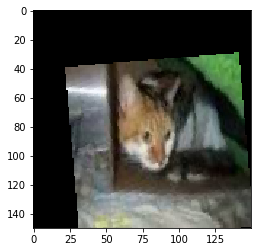

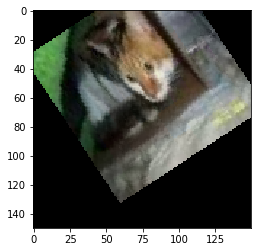

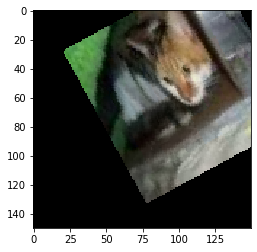

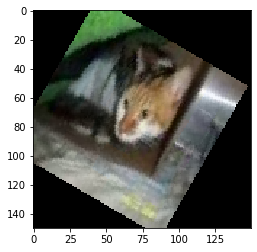

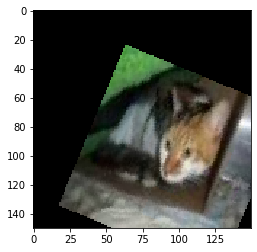

In [5]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
# img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

img = Image.open(img_path)
x = np.array(img)  # Numpy array with shape (150, 150, 3)
# trans = transforms.Compose([
#     transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
# ])
# x = trans(x).unsqueeze(0)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!        
for i in range(5):
    plt.figure(i)
    trans_img = trans(x).permute(1, 2, 0)
    print(trans_img.shape)
    imgplot = plt.imshow(trans_img)

## Add Data Augmentation to the Preprocessing Step

Now let's add our data-augmentation transformations from [**Exploring Data Augmentation**](#scrollTo=E3sSwzshfSpE) to our data preprocessing configuration:

In [6]:
test_tfm = transforms.Compose([        
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=40, scale=(0.8, 0.8), translate=(0.2, 0.2), shear=0.2),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
])

train_set = ImageFolder(root=train_dir, transform = test_tfm)
val_set = ImageFolder(root=validation_dir, transform = test_tfm)

In [7]:
batch_size=20
# The following variables are the hyperparameters.
learning_rate = 0.001
n_epochs = 30

train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(val_set,batch_size=batch_size,shuffle=True)

If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

## Adding Dropout

Another popular strategy for fighting overfitting is to use **dropout**.

**TIP:** To learn more about dropout, see [Training Neural Networks](https://developers.google.com/machine-learning/crash-course/training-neural-networks/video-lecture) in [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

Let's reconfigure our convnet architecture from Exercise 1 to add some dropout, right before the final classification layer:

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 150, 150] 
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 0),  # [16, 148, 148]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(16, 32, 3, 1, 0), # [128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]
            
            nn.Conv2d(32, 64, 3, 1, 0), # [128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

        )
        self.fc = nn.Sequential(
            nn.Flatten(),             
            nn.Linear(64*17*17, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()        # 表示第i个样本的经过sigmoid的预测概率   
        )

    def forward(self, x):
        out = self.cnn(x)
        # out = out.view(out.size()[0], -1)
        out = self.fc(out)
        # out = out.view(-1)
        return out
    
model = Classifier().to(device)    

In [9]:
model

from torchinfo import summary
summary(model, input_size=(15, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               --                        --
├─Sequential: 1-1                        [15, 64, 17, 17]          --
│    └─Conv2d: 2-1                       [15, 16, 148, 148]        448
│    └─ReLU: 2-2                         [15, 16, 148, 148]        --
│    └─MaxPool2d: 2-3                    [15, 16, 74, 74]          --
│    └─Conv2d: 2-4                       [15, 32, 72, 72]          4,640
│    └─ReLU: 2-5                         [15, 32, 72, 72]          --
│    └─MaxPool2d: 2-6                    [15, 32, 36, 36]          --
│    └─Conv2d: 2-7                       [15, 64, 34, 34]          18,496
│    └─ReLU: 2-8                         [15, 64, 34, 34]          --
│    └─MaxPool2d: 2-9                    [15, 64, 17, 17]          --
├─Sequential: 1-2                        [15, 1]                   --
│    └─Flatten: 2-10                     [15, 18496]               --
│    └─

## Retrain the Model

With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.) See if you can write the code yourself:


In [10]:
from torch.autograd import Variable

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

loss_func = nn.BCELoss() 
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_train_acc = []

epoch_valid_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch 
        # print(X.shape) # torch.Size([5, 3, 150, 150])
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device)
        y_hat = model(X)       
        
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y)
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device) 
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y) 
        
        valid_accs.append(acc)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accs = sum(valid_accs) / len(valid_accs)
    epoch_valid_loss.append(valid_loss)
    epoch_valid_acc.append(valid_accs)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/030 ]           train_loss = 1.15600 accuracy = 0.49800  |           valid_loss = 0.68929 val_accuracy = 0.50300



[ Epoch | 002/030 ]           train_loss = 0.69147 accuracy = 0.51200  |           valid_loss = 0.68665 val_accuracy = 0.58500



[ Epoch | 003/030 ]           train_loss = 0.68199 accuracy = 0.55300  |           valid_loss = 0.65789 val_accuracy = 0.58800



[ Epoch | 004/030 ]           train_loss = 0.67302 accuracy = 0.59600  |           valid_loss = 0.64478 val_accuracy = 0.59000



[ Epoch | 005/030 ]           train_loss = 0.65260 accuracy = 0.59450  |           valid_loss = 0.64952 val_accuracy = 0.62800



[ Epoch | 006/030 ]           train_loss = 0.70793 accuracy = 0.59800  |           valid_loss = 0.63710 val_accuracy = 0.63400



[ Epoch | 007/030 ]           train_loss = 0.65395 accuracy = 0.60200  |           valid_loss = 0.63624 val_accuracy = 0.63200



[ Epoch | 008/030 ]           train_loss = 0.66720 accuracy = 0.63000  |           valid_loss = 0.62127 val_accuracy = 0.63400



[ Epoch | 009/030 ]           train_loss = 0.63242 accuracy = 0.62650  |           valid_loss = 0.61189 val_accuracy = 0.68400



[ Epoch | 010/030 ]           train_loss = 0.61844 accuracy = 0.66100  |           valid_loss = 0.59517 val_accuracy = 0.68700



[ Epoch | 011/030 ]           train_loss = 0.62010 accuracy = 0.65900  |           valid_loss = 0.59593 val_accuracy = 0.68700



[ Epoch | 012/030 ]           train_loss = 0.60517 accuracy = 0.67250  |           valid_loss = 0.64303 val_accuracy = 0.64300



[ Epoch | 013/030 ]           train_loss = 0.61085 accuracy = 0.68150  |           valid_loss = 0.58147 val_accuracy = 0.69400



[ Epoch | 014/030 ]           train_loss = 0.59856 accuracy = 0.67250  |           valid_loss = 0.60749 val_accuracy = 0.66600



[ Epoch | 015/030 ]           train_loss = 0.60049 accuracy = 0.67850  |           valid_loss = 0.60136 val_accuracy = 0.68100



[ Epoch | 016/030 ]           train_loss = 0.58955 accuracy = 0.68550  |           valid_loss = 0.59212 val_accuracy = 0.67200



[ Epoch | 017/030 ]           train_loss = 0.58551 accuracy = 0.69800  |           valid_loss = 0.57797 val_accuracy = 0.70000



[ Epoch | 018/030 ]           train_loss = 0.57520 accuracy = 0.70400  |           valid_loss = 0.58757 val_accuracy = 0.69700



[ Epoch | 019/030 ]           train_loss = 0.56980 accuracy = 0.70850  |           valid_loss = 0.57715 val_accuracy = 0.69000



[ Epoch | 020/030 ]           train_loss = 0.55680 accuracy = 0.71300  |           valid_loss = 0.62508 val_accuracy = 0.64000



[ Epoch | 021/030 ]           train_loss = 0.56045 accuracy = 0.70650  |           valid_loss = 0.56392 val_accuracy = 0.69900



[ Epoch | 022/030 ]           train_loss = 0.55748 accuracy = 0.70800  |           valid_loss = 0.59008 val_accuracy = 0.68600



[ Epoch | 023/030 ]           train_loss = 0.54592 accuracy = 0.72400  |           valid_loss = 0.56708 val_accuracy = 0.70200



[ Epoch | 024/030 ]           train_loss = 0.53817 accuracy = 0.72800  |           valid_loss = 0.55833 val_accuracy = 0.71300



[ Epoch | 025/030 ]           train_loss = 0.53986 accuracy = 0.74200  |           valid_loss = 0.55908 val_accuracy = 0.71000



[ Epoch | 026/030 ]           train_loss = 0.52845 accuracy = 0.73900  |           valid_loss = 0.54437 val_accuracy = 0.74800



[ Epoch | 027/030 ]           train_loss = 0.51649 accuracy = 0.73950  |           valid_loss = 0.53816 val_accuracy = 0.73500



[ Epoch | 028/030 ]           train_loss = 0.53251 accuracy = 0.74300  |           valid_loss = 0.61035 val_accuracy = 0.69800



[ Epoch | 029/030 ]           train_loss = 0.52240 accuracy = 0.74900  |           valid_loss = 0.53069 val_accuracy = 0.74600



[ Epoch | 030/030 ]           train_loss = 0.49393 accuracy = 0.77250  |           valid_loss = 0.53980 val_accuracy = 0.73100
Defined the build_model and train_model functions.


Note that with data augmentation in place, the 2,000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

Text(0.5, 1.0, 'Training and validation loss')

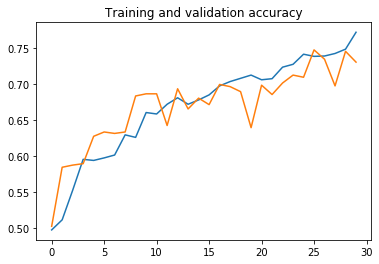

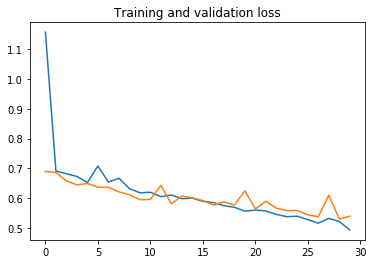

In [11]:
import matplotlib.pyplot as plt

# Get number of epochs
epochs = range(len(epoch_train_acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, epoch_train_acc)
plt.plot(epochs, epoch_valid_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, epoch_train_loss)
plt.plot(epochs, epoch_valid_loss)
plt.title('Training and validation loss')

Much better! We are no longer overfitting, and we have gained ~3 validation accuracy percentage points (see the green line in the top chart). In fact, judging by our training profile, we could keep fitting our model for 30+ more epochs and we could probably get to ~80%!

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)